# Exercise 4: recommender System

In [90]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [91]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [92]:
def getTopN(movie_id,D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [93]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [94]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

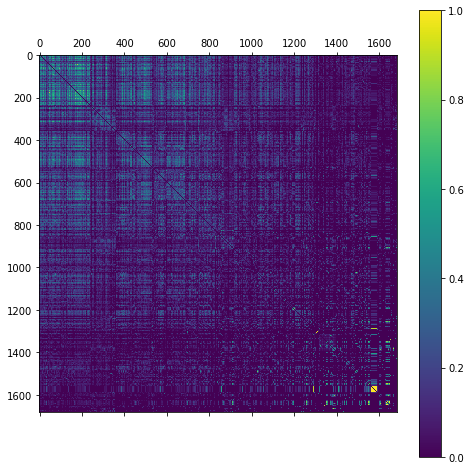

In [95]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D)
plt.colorbar()

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [96]:
D2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
D2=np.abs(np.nan_to_num(D2-1)) #dist to similarity 
np.fill_diagonal(D2,0) #set self-dist to zero

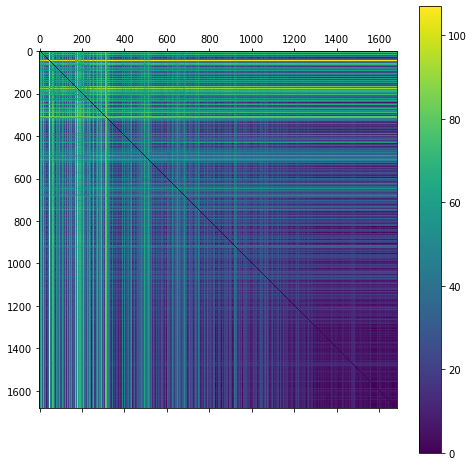

In [97]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(D2)
plt.colorbar()

In [98]:
from sklearn.model_selection import train_test_split

R_train, R_test = train_test_split(R, test_size=0.1)

In [99]:
test_cos=test_Score(D,R_test)
test_l2=test_Score(D2,R_test)

print("cos:",np.mean(test_cos), "L2:",np.mean(test_l2))


cos: 2.527157894736842 L2: 1.528421052631579


## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [107]:
def randomMovies(Id, D):
    x = np.shape(D)[0]
    return np.random.randint(x, size=5)

def topMovies(Id, D):
    s = np.sum(D, axis=0)
    return np.argsort(s)[-5:]

def Score_byID(ID, D, Test, F):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = F(ID,D)[::-1]
    res_title = getNameByID(F(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test, Function):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i], Function)
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [109]:

test_random = test_Score(D, R_test, randomMovies)
test_top = test_Score(D, R_test, topMovies)

print("Mean scores on test: cos:",np.mean(test_cos), "random:",np.mean(test_random), "top 5:",np.mean(test_top))


Mean scores on test: cos: 2.527157894736842 random: 0.23031578947368422 top 5: 1.6736842105263159


## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


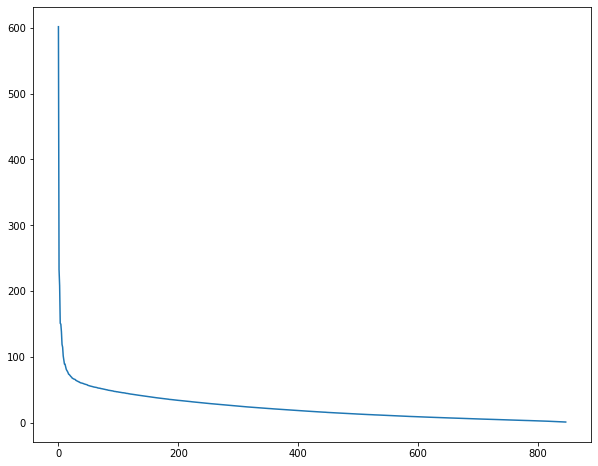

In [130]:
U,S,V=np.linalg.svd(R_train)

plt.plot(S)

(array([811.,  31.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.83308724,  60.93910188, 121.04511653, 181.15113117,
        241.25714581, 301.36316045, 361.46917509, 421.57518974,
        481.68120438, 541.78721902, 601.89323366]),
 <a list of 10 Patch objects>)

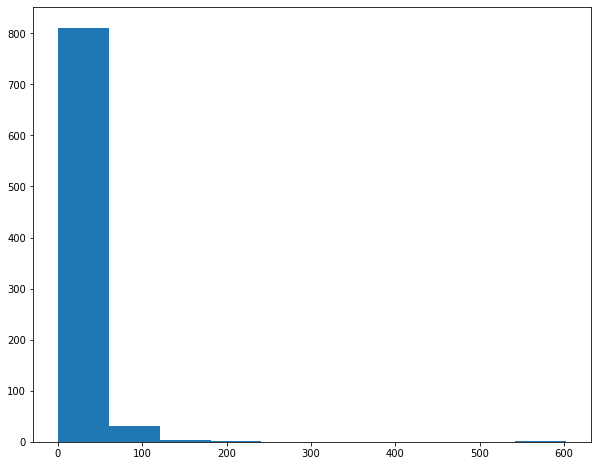

In [131]:
plt.hist(S)

In [132]:
(width,height) = (U).shape

np.allclose(R_train, np.dot(U * S, V[:width,:]))

True

In [133]:
# now reconstruct with loss
cut = 200 #select how many dims we want to keep
R_approx = np.dot(U[:,:cut] * S[:cut], V[:cut,:])

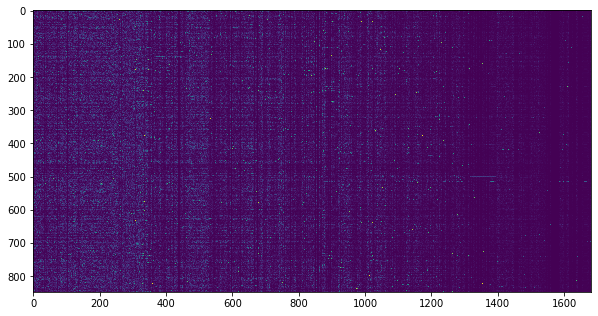

In [134]:
# show differnence
plt.imshow(np.abs(R_train-R_approx))

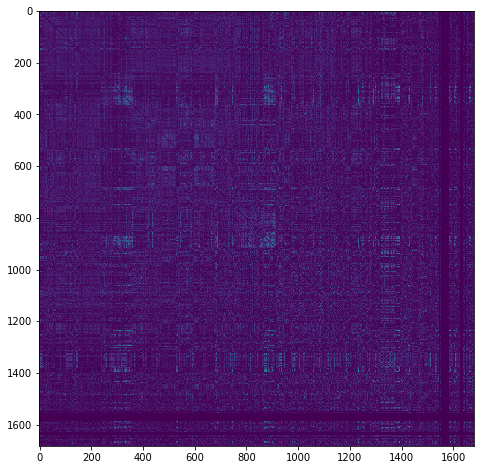

In [136]:
#compute D from R and R_approx
# NOTE: in practice, we would not do this (becase D is as large as before) and would compute the distance when needed.
#Now we compute a full D for simplicity (we cann use the same tools as before)

D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

D_approx=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_approx.T, metric='cosine'))
D_approx=np.abs(np.nan_to_num( D_approx-1)) #dist to similarity 
np.fill_diagonal(D_approx,0) #set self-dist to zero

plt.imshow(np.abs(D-D_approx))

In [141]:
test_approx=test_Score(D_approx,R_test,getTopN)
print("Mean scores on test: full cos:",np.mean(test_cos), "approx cos:",np.mean(test_approx))

Mean scores on test: full cos: 2.527157894736842 approx cos: 2.086315789473684
